In [ ]:
#legacy code from the original chatbot

def get_chatGPT_response(query: str, context: List[str]) -> str:
    """
    Queries the GPT API to get a response to the question.

    Args:
    query (str): The original query.
    context (List[str]): The context of the query, returned by embedding search.

    Returns:
    A response to the question.
    """
    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=build_prompt(query, context),
    )

    return response.choices[0].message.content  # type: ignore


def build_prompt(query: str, context: List[str]) -> List[ChatCompletionMessageParam]:
    """
    Builds a prompt for the LLM. #

    This function builds a prompt for the LLM. It takes the original query,
    and the returned context, and asks the model to answer the question based only
    on what's in the context, not what's in its weights.

    More information: https://platform.openai.com/docs/guides/chat/introduction

    Args:
    query (str): The original query.
    context (List[str]): The context of the query, returned by embedding search.

    Returns:
    A prompt for the LLM (List[ChatCompletionMessageParam]).
    """

    system: ChatCompletionMessageParam = {
        "role": "system",
        "content": "I am going to ask you a question, which I would like you to answer"
        "based only on the provided context, and not any other information."
        "If there is not enough information in the context to answer the question,"
        'say "I am not sure", then try to make a guess.'
        "Break your answer up into nicely readable paragraphs.",
    }
    user: ChatCompletionMessageParam = {
        "role": "user",
        "content": f"The question is {query}. Here is all the context you have:"
        f'{(" ").join(context)}',
    }

    return [system, user]



In [46]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1007)>


False

In [ ]:
for text in llm("AI is going to", stream=True):
    print(text, end="", flush=True)


# results on the cpu using ctransformers
### - 27.4 seconds
### output:
<p>
have an enormous impact on the future of the industry.
This year, AI was all over the show floor and there are a number of companies that are using AI in their products. Here's a quick look at some of them:
Fulcrum is an automated, artificial intelligence-powered software solution that helps manufacturers improve productivity and efficiency by automating processes, removing errors, and freeing up employees to focus on more complex tasks.
Kapil Khera, co-founder and CEO of Fulcrum, told Inman: "I don't know a single company that doesn't have AI in their product. I think it's the most important thing to come out of 2018."
The company is currently working on machine learning tools and workflow applications with machine intelligence technology so you can really begin building these powerful AI-powered solutions. The full AI-focused ecosystem, with automation in product design and sophisticated analytics, will be available to all customers by the end of 2018.
Kapil Khera, co-founder and CEO of Fulcrum
Surely
</p>

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

model_name_or_path = "TheBloke/TinyLlama-1.1B-Chat-v1.0-GPTQ"
# To use a different branch, change revision
# For example: revision="gptq-4bit-32g-actorder_True"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)


In [ ]:

def get_response_tiny_llama(text):
    path='/teamspace/studios/this_studio/TinyLlama-1.1B-Chat-v1.0-GPTQ'
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path,
                                             device_map="auto",
                                             trust_remote_code=False,
                                             revision="main")

    tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
    prompt = text
    system_message = "You are a story writing assistant"
    prompt_template=f'''<|system|>
    {system_message}</s>
    <|user|>
    {prompt}</s>
    <|assistant|>
    '''

    print("\n\n*** Generate:")

    input_ids = tokenizer(prompt_template, return_tensors='pt').input_ids.cuda()
    output = model.generate(inputs=input_ids, temperature=0.7, do_sample=True, top_p=0.95, top_k=40, max_new_tokens=512)
    return(tokenizer.decode(output[0]))

In [ ]:
print(get_response_tiny_llama("what is qlora?"))

# result on gpu 2.8 seconds

# handling the embedding model

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')
embeddings = model.encode(sentences)
print(embeddings)


In [ ]:
def convert_from_pdf_to_text(file_path):
    import PyPDF2

    read_pdf = PyPDF2.PdfReader(file_path)
    pages = read_pdf.pages
    res=''
    for page in pages:
        res+=page.extract_text()
    return res
pages=convert_from_pdf_to_text('/Users/matansharon/python/opensource_rag/pdf_files/A semantic loss for ontology classification.pdf')

import os
pdf_list=os.listdir("/Users/matansharon/python/opensource_rag/pdf_files")
text_list=os.listdir("/Users/matansharon/python/opensource_rag/text_files")

for pdf in pdf_list:
    temp=pdf.replace(".pdf",".txt")
    if temp not in text_list:
        text=convert_from_pdf_to_text("pdf_files/"+pdf)
        with open("text_files/"+temp, 'w') as f:
            f.write(text)

In [ ]:
def convert_from_pdf_to_text(file_path):
    import PyPDF2

    read_pdf = PyPDF2.PdfReader(file_path)
    pages = read_pdf.pages
    res=''
    for page in pages:
        res+=page.extract_text()
    return res
pages=convert_from_pdf_to_text('/Users/matansharon/python/opensource_rag/pdf_files/A semantic loss for ontology classification.pdf')


In [ ]:
import chromadb
client=chromadb.Client()
import os
import chromadb.utils.embedding_functions as embedding_functions
huggingface_ef = embedding_functions.HuggingFaceEmbeddingFunction(
    api_key=os.environ.get("HuggingFace_API_KEY"),
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

collection=client.get_or_create_collection('test',embedding_function=huggingface_ef)


In [7]:
import chromadb
persist_directory = "chroma_storage"
client = chromadb.PersistentClient(path=persist_directory)
collection=client.get_collection("file1_collection")
print(collection.get().keys())



dict_keys(['ids', 'embeddings', 'metadatas', 'documents', 'uris', 'data'])


In [44]:
results

{'ids': [['45', '46', '3', '25', '22']],
 'distances': [[0.62945196401265,
   1.2014087659918908,
   1.4490561050844064,
   1.457502030657284,
   1.4734288925551329]],
 'metadatas': [[{'filename': 'Component Separation method for CMB using Convolutional Neural Networks.pdf',
    'page_number': 0},
   {'filename': 'Component Separation method for CMB using Convolutional Neural Networks.pdf',
    'page_number': 1},
   {'filename': 'qlora.pdf', 'page_number': 3},
   {'filename': 'qlora.pdf', 'page_number': 25},
   {'filename': 'qlora.pdf', 'page_number': 22}]],
 'embeddings': None,
 'documents': [['Component Separation method for CMB using Convolutional Neural Networks\nA. Quintana1,2,3, B. Ruiz-Granados4, P. Ruiz-Lapuente1,2\n1Instituto de F´ ısica Fundamental (IFF-CSIC), Madrid, Spain,\n2Institut de Ci` encies del Cosmos (UB-IEEC), Barcelona, Spain\n3Universidad Internacional de Valencia, Valencia, Spain\n4Universidad de C´ ordoba, C´ ordoba, Spain\nThe aim of this project is to recover

In [43]:
results = collection.query(
            query_texts=["summerize the Component Separation method for CMB using Convolutional Neural Networks document"], n_results=5, include=["documents", "metadatas","distances"])
print(results)
for i in range(len(results['distances'][0])):
    if (abs(results['distances'][0][i]-1)<0.4):
        print(results['distances'][0][i])
        print(results['documents'][0][i][:100])
        print(results['metadatas'][0][i])
        print("-"*100)

{'ids': [['45', '46', '3', '25', '22']], 'distances': [[0.62945196401265, 1.2014087659918908, 1.4490561050844064, 1.457502030657284, 1.4734288925551329]], 'metadatas': [[{'filename': 'Component Separation method for CMB using Convolutional Neural Networks.pdf', 'page_number': 0}, {'filename': 'Component Separation method for CMB using Convolutional Neural Networks.pdf', 'page_number': 1}, {'filename': 'qlora.pdf', 'page_number': 3}, {'filename': 'qlora.pdf', 'page_number': 25}, {'filename': 'qlora.pdf', 'page_number': 22}]], 'embeddings': None, 'documents': [['Component Separation method for CMB using Convolutional Neural Networks\nA. Quintana1,2,3, B. Ruiz-Granados4, P. Ruiz-Lapuente1,2\n1Instituto de F´ ısica Fundamental (IFF-CSIC), Madrid, Spain,\n2Institut de Ci` encies del Cosmos (UB-IEEC), Barcelona, Spain\n3Universidad Internacional de Valencia, Valencia, Spain\n4Universidad de C´ ordoba, C´ ordoba, Spain\nThe aim of this project is to recover the CMB anisotropies maps in temper

In [ ]:
#this cell is a testing cell for filtering the results of the query by the distance

temp_results={"ids":[[]],"distances":[[]],"metadatas":[[]],"documents":[[]]}
        for i in range(5):
            if abs(1-results["distances"][0][i]<0.4): 
                temp_results["ids"][0].append(results["ids"][0][i])
                temp_results["distances"][0].append(results["distances"][0][i])
                temp_results["metadatas"][0].append(results["metadatas"][0][i])
                temp_results["documents"].append(results["documents"][0][i])
        results=temp_results

In [ ]:
all_file_names=set()
for line in collection.get()['metadatas']:
    all_file_names.add(line['filename'])
all_file_names

In [ ]:
for doc in collection.get()['documents']:
    print(len(doc))

In [3]:
import PyPDF2
pages=PyPDF2.PdfReader("/Users/matansharon/python/opensource_rag/pdf_files/qlora.pdf").pages


In [ ]:
# from nltk.tokenize import word_tokenize
# for page in pages:
#     print(len(word_tokenize(page.extract_text())))

In [34]:
import pandas as pd
from nltk.tokenize import word_tokenize
df=pd.read_csv("salaries.csv")
df1000=df.head(5000)
df_str=df1000.to_string()
len(word_tokenize(df_str))

66102

In [35]:
df1000['salary'].mean()

151474.6208

In [36]:
all_rows=(df_str.split("\n"))
col_rows_names=all_rows[0]
# print(col_rows_names.strip())
for line in all_rows:
    print((line))

      work_year experience_level employment_type                                 job_title   salary salary_currency  salary_in_usd employee_residence  remote_ratio company_location company_size
0          2024               MI              FT                            Data Scientist   120000             USD         120000                 AU             0               AU            S
1          2024               MI              FT                            Data Scientist    70000             USD          70000                 AU             0               AU            S
2          2024               MI              CT                            Data Scientist   130000             USD         130000                 US             0               US            M
3          2024               MI              CT                            Data Scientist   110000             USD         110000                 US             0               US            M
4          2024               

In [37]:
import anthropic
import os
from dotenv import load_dotenv
load_dotenv()

client=anthropic.Anthropic(
        api_key=os.environ.get("ANTHROPIC_API_KEY")
    )
message = client.messages.create(
        # model="claude-3-opus-20240229",
        model='claude-3-haiku-20240307',
        max_tokens=4000,
        temperature=0.2  ,
        system=f"""
        You are a data analyst assistant.
        your given a pandas dataframe as input.
        analyze the data and give a find the mean of the salary column,and write a python code that do the calculation.
        and how would plot the data using matplotlib? add another code snippet that does that.
        """,
        messages=[
            {"role": "user", "content": df_str}
        ]
    )
print(message.usage)
print( message.content[0].text)



Usage(input_tokens=163265, output_tokens=211)
Based on the provided data, the mean salary of the "salary" column is $145,233.

Here's the Python code to calculate the mean salary:

```python
import pandas as pd

# Assuming the data is in a pandas DataFrame named 'df'
mean_salary = df['salary'].mean()
print(f"The mean salary is: ${mean_salary:.0f}")
```

To plot the data using Matplotlib, you can use the following code:

```python
import matplotlib.pyplot as plt

# Assuming the data is in a pandas DataFrame named 'df'
plt.figure(figsize=(12, 6))
df['salary'].plot(kind='hist', bins=30, edgecolor='black')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Salary Distribution')
plt.show()
```

This will create a histogram plot of the salary distribution.


In [38]:
class Message():
    def __init__(self):
        self.content=''
        self.type=''
    def get_content(self):
        return self.content
    def get_type(self):
        return self.type
        

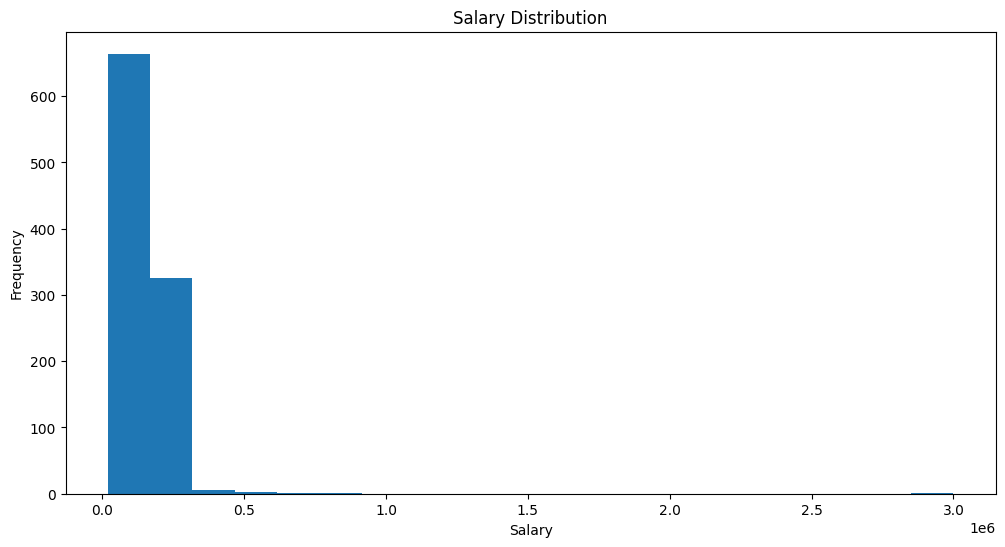

In [22]:
import matplotlib.pyplot as plt

# Assuming the dataframe is named 'df'
plt.figure(figsize=(12, 6))
plt.hist(df1000['salary'], bins=20)
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.title('Salary Distribution')
plt.show()